# METHODOLOGY - EMOTION RECOGNITION

# Data

In [1]:
# tf 1.15 for capsnet
# cudnn 7.4, cuda = 10.0
# matplotlin, seaborn
# sklearn

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import numpy as np
import pandas as pd
from glob import glob

In [4]:
files = glob("../data/project_data/data_*_80_ratio.csv")
print(files)
test_df = pd.read_csv(files[0])
train_df = pd.read_csv('../data/project_data/balanced_undersampled_train.csv')

# val_df = pd.read_csv(files[2])
train_df

['../data/project_data\\data_test_80_ratio.csv', '../data/project_data\\data_train_80_ratio.csv', '../data/project_data\\data_val_80_ratio.csv']


,text,sentiment
0,for fucks sake just using chrome use firefox a...,Happy
1,mini giveaway prize 1 official pc1 taehyung be...,Happy
2,happy bihday stay safe and mbtc kitakits nalan...,Happy
3,i hate to study especially math but need to be...,Happy
4,hahahahaha just like it joves itcho's tired da...,Happy
...,...,...
11560,bat suddenly became 96 lesson pan ko gago,Sad
11561,asdfghjkl yoko first study tara at myx perfect...,Sad
11562,just i do not have a test i have a test later ...,Sad
11563,kelan so it will study at harvard because she ...,Sad


In [6]:
r_train_x, r_train_y = train_df['text'], train_df['sentiment']
# r_val_x, r_val_y = val_df['text'], val_df['sentiment']
r_test_x, r_test_y = test_df['text'], test_df['sentiment']
len(r_train_x)

11565

Fear = 1836 (28.51 %)
Surprise = 1750 (27.18 %)
Sad = 1555 (24.15 %)
Happy = 862 (13.39 %)
Angry = 436 (6.77 %)
Total Count: 6439 



C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


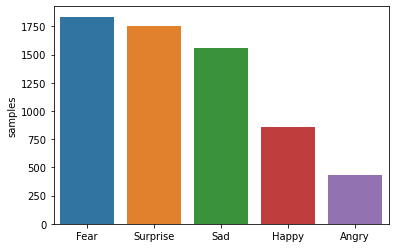

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
def get_distribution(data):
    x_count = data.value_counts()
    for i in range(len(x_count)):
        print(f"{x_count.index[i]} = {x_count[i]} ({round((x_count[i]/sum(x_count)) * 100, 2)} %)")
    print(f"Total Count: {sum(x_count)} \n")    
    sns.barplot(x_count.index, x_count)
    plt.gca().set_ylabel('samples')
    
get_distribution(r_test_y)

Surprise = 2313 (20.0 %)
Fear = 2313 (20.0 %)
Sad = 2313 (20.0 %)
Angry = 2313 (20.0 %)
Happy = 2313 (20.0 %)
Total Count: 11565 



C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


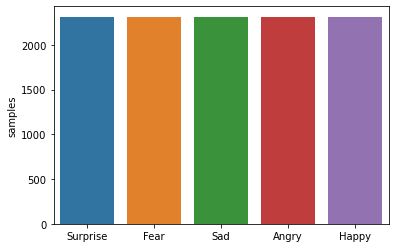

In [8]:
get_distribution(r_train_y)

# Tokenization

In [9]:
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from math import ceil
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from matplotlib import pyplot as plt

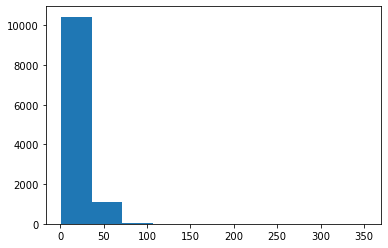

In [10]:
# see distribution
train_text_len = [len(i.split()) for i in r_train_x]
plt.hist(train_text_len)
plt.show()
# hellow word = len 2

In [12]:
# count words
def count_words(sentences):
    counts = {}
    for s in sentences:
        for word in s.split():
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    return counts

max_len = 65 # based from the word distribution above
max_features = len(count_words(r_train_x))
print("max_len",max_len,"max_features", max_features)

# tokenizer
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(r_train_x)

# convert words to numbers
train_x = tokenizer.texts_to_sequences(r_train_x)
# val_x = tokenizer.texts_to_sequences(r_val_x)
test_x = tokenizer.texts_to_sequences(r_test_x)

# pad sentences
# max_len = min(max_len, len(max(train_x, key=len)))
# [hellow world]  
# [1 2] max le = 5
# [1 2 0 0 0]
# [1 2 3 4 5]
train_x = sequence.pad_sequences(train_x, padding="pre",maxlen=max_len, truncating="post")
# val_x = sequence.pad_sequences(val_x, padding="pre",maxlen=max_len, truncating="post")
test_x = sequence.pad_sequences(test_x, padding="pre",maxlen=max_len, truncating="post")

max_len 65 max_features 21473


In [14]:
# label binarizer : fear = 1, happy =2, ...
lb = LabelBinarizer()
lb.fit(r_train_y)

# use inverse_transform to get the original class names
train_y = lb.transform(r_train_y)
# val_y = lb.transform(r_val_y)
test_y = lb.transform(r_test_y)


In [15]:
for i in range(10):
    print(f"label '{r_test_y[i]}' :: encoding {test_y[i]}")

label 'Fear' :: encoding [0 1 0 0 0]
label 'Fear' :: encoding [0 1 0 0 0]
label 'Surprise' :: encoding [0 0 0 0 1]
label 'Sad' :: encoding [0 0 0 1 0]
label 'Sad' :: encoding [0 0 0 1 0]
label 'Happy' :: encoding [0 0 1 0 0]
label 'Sad' :: encoding [0 0 0 1 0]
label 'Sad' :: encoding [0 0 0 1 0]
label 'Fear' :: encoding [0 1 0 0 0]
label 'Surprise' :: encoding [0 0 0 0 1]


# embeddings


In [16]:
%%time
# emb_file = "../data/glove.6B.100d.txt"
# emb_size = 100 # glove 100d
# emb_file = "../data/glove.twitter.27B.50d.txt"
# emb_size = 50


# get the word embeddings
emb_file = "../data/glove.twitter.27B.100d.txt" # <- 
# emb_file = "../data/glove.twitter.27B.50d.txt" # <- 80-82% test acc
# emb_file = "../data/glove.twitter.27B.25d.txt" # <- 76 %
emb_size = 100 #50 #100


Wall time: 0 ns


In [17]:
def extract_emb(emb_file):
    # extract the embedding data
    embeddings_index = {}
    f = open(emb_file, encoding="utf8") 
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
        
    print(f'Found {len(embeddings_index)} word vectors.')
    return embeddings_index
    
def get_embedding_matrix(emb_file, emb_size):
    embeddings_index = extract_emb(emb_file)

    # get the embedding matrix
    word_index = tokenizer.word_index
    nb_words = max_features #min(max_features, len(word_index))

    # do we nee to add plus 1 in nb_words?
    embedding_matrix = np.zeros((nb_words, emb_size)) 

    for word, i in word_index.items():
        if i >= nb_words: continue # disregard first
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Model

In [18]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report, f1_score
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.initializers import *
from tensorflow.keras.optimizers import *

# hyper parameter tuning
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
# study how attenion layer works
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'step_dim': self.step_dim,
            'W_regularizer': self.W_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'b_constraint': self.b_constraint,
            'bias':self.bias
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [20]:


# F1
class F1Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_pred = (y_pred > 0.35).astype(int)
            score = f1_score(self.y_val, y_pred, average="micro")
            print("\n F1 Score - epoch: %d - score: %.6f \n" % (epoch+1, score))

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

def get_predict_metrics(pred, test_y):
    # classification report
    pred_y = np.argmax(pred, axis=1)
    true_y = np.argmax(test_y, axis=1)
    print(classification_report(true_y, pred_y))

    # visualize confusion matrix
    
    mlt_cm = multilabel_confusion_matrix(true_y, pred_y)
    labels = ["".join("c" + str(i)) for i in range(0, 6)]
    fig, ax = plt.subplots(5, 1, figsize=(12, 20))
    for axes, cfs_matrix, label in zip(ax.flatten(), mlt_cm, labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.show()    
    
    
# model plot
def make_plot(loss, val_loss, acc, val_acc):
    t = np.arange(1,len(loss)+1,1)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
    plt.subplots_adjust(wspace=0.2)

    ax1.plot(t, loss)
    ax1.plot(t, val_loss)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title('Train vs Val loss')
    ax1.legend(['train','val'], ncol=2, loc='upper right')

    ax2.plot(t, acc)
    ax2.plot(t, val_acc)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('acc')
    ax2.set_title('Train vs Val acc')
    ax2.legend(['train','val'], ncol=2, loc='upper right')

    plt.show();

## MODELS

In [21]:

def BiGRUAttenGPU(input_dropout = 0.25, inter_dropout = 0.25,spatial_dropout = True, gru_units=[64], dense_units=[32], 
                  has_flatten=False, mask_zero = False, has_capsule=[]):
    
    # input layers
    inp = Input(shape=(max_len, ))
    
    # embedding layers
    x = Embedding(max_features,emb_size,weights=[embedding_matrix],trainable=False, mask_zero=mask_zero)(inp)# mask_zero is to ignore the zero paddings
    
    # dropout layer
    if input_dropout != 1: # if 1 = no dropout
        if spatial_dropout:
            x = SpatialDropout1D(input_dropout)(x)

        else:
            x = Dropout(input_dropout)(x)
            
    # BiGRU layer
    for gru_unit in gru_units:
        x = Bidirectional(GRU(gru_unit, return_sequences=True, activation='tanh', recurrent_activation = 'sigmoid', recurrent_dropout=0, unroll=False, use_bias=True, reset_after =True))(x) # setup for GPU GRU
    
    # attention layer
    x = Attention(max_len)(x)
    x = Dropout(inter_dropout)(x)
    
    # capsule layer
    if len(has_capsule) != 0: # capsule should be list containing the three param below
        x = Capsule(num_capsule=10, dim_capsule=10, routings=4, share_weights=True)(x)
        x = Flatten()(x)
        
    # conv layer
#     for cnn_unit in cnn_units:
#         x = Conv1D()
    
    # dense layer
    for dense_unit in dense_units:
        x = Dense(dense_unit, activation="relu")(x) # 256
        if inter_dropout != 1: # if 1 = no dropout
            x = Dropout(inter_dropout)(x)
    
    # flatten layer
    if has_flatten:
        x = Flatten()(x)
    
    # classification layer
    x = Dense(5, activation="softmax")(x)
    
    # build model
    model = Model(inputs=inp, outputs=x, name='BiGRUAttenGPU')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model



without dropout = 80% for 100d word embedding

In [22]:
# from tqdm import tqdm,trange
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model


## Neural Network - Brute Force Search

In [23]:
emb_size = 100
emb_file = "../data/glove.twitter.27B.100d.txt"
embedding_matrix = get_embedding_matrix(emb_file, emb_size)

# emb_size = 50
# emb_file = "../data/glove.twitter.27B.50d.txt"
# embedding_matrix = get_embedding_matrix(emb_file, emb_size)

Found 1193514 word vectors.


In [24]:
from tqdm import tqdm

In [25]:
emb_size

100

Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
_________________________________________________________________
dropout (Dropout)            (None, 65, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 65, 48)            18144     
_________________________________________________________________
attention (Attention)        (None, 48)                113       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 12)              

37/37 [==============================] - 1s 29ms/step - loss: 0.6542 - acc: 0.7613 - val_loss: 8.7377 - val_acc: 0.0000e+00
Epoch 50/256
37/37 [==============================] - 1s 32ms/step - loss: 0.6469 - acc: 0.7657 - val_loss: 8.7417 - val_acc: 0.0000e+00
Epoch 51/256
37/37 [==============================] - 1s 34ms/step - loss: 0.6346 - acc: 0.7630 - val_loss: 8.8538 - val_acc: 0.0000e+00
Epoch 52/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6364 - acc: 0.7690 - val_loss: 8.8793 - val_acc: 0.0000e+00
Epoch 53/256
37/37 [==============================] - 1s 30ms/step - loss: 0.6311 - acc: 0.7674 - val_loss: 8.9039 - val_acc: 0.0000e+00
Epoch 54/256
37/37 [==============================] - 1s 34ms/step - loss: 0.6265 - acc: 0.7732 - val_loss: 8.9160 - val_acc: 0.0000e+00
Epoch 55/256
37/37 [==============================] - 1s 36ms/step - loss: 0.6172 - acc: 0.7759 - val_loss: 9.2910 - val_acc: 0.0000e+00
Epoch 56/256
37/37 [==============================] - 

37/37 [==============================] - 1s 29ms/step - loss: 0.4777 - acc: 0.8283 - val_loss: 11.7396 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 1s 28ms/step - loss: 0.4741 - acc: 0.8328 - val_loss: 12.0245 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 1s 28ms/step - loss: 0.4771 - acc: 0.8311 - val_loss: 11.2931 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [==============================] - 1s 31ms/step - loss: 0.4678 - acc: 0.8352 - val_loss: 12.0202 - val_acc: 0.0000e+00
Epoch 112/256
37/37 [==============================] - 1s 30ms/step - loss: 0.4727 - acc: 0.8306 - val_loss: 12.3521 - val_acc: 0.0000e+00
Epoch 113/256
37/37 [==============================] - 1s 29ms/step - loss: 0.4554 - acc: 0.8378 - val_loss: 12.3691 - val_acc: 0.0000e+00
Epoch 114/256
37/37 [==============================] - 1s 30ms/step - loss: 0.4527 - acc: 0.8400 - val_loss: 12.0872 - val_acc: 0.0000e+00
Epoch 115/256
37/37 [====================

37/37 [==============================] - 1s 29ms/step - loss: 0.4074 - acc: 0.8580 - val_loss: 14.1457 - val_acc: 0.0000e+00
Epoch 168/256
37/37 [==============================] - 1s 28ms/step - loss: 0.3932 - acc: 0.8572 - val_loss: 14.3278 - val_acc: 0.0000e+00
Epoch 169/256
37/37 [==============================] - 1s 28ms/step - loss: 0.3855 - acc: 0.8626 - val_loss: 14.3987 - val_acc: 0.0000e+00
Epoch 170/256
37/37 [==============================] - 1s 29ms/step - loss: 0.4063 - acc: 0.8543 - val_loss: 13.9848 - val_acc: 0.0000e+00
Epoch 171/256
37/37 [==============================] - 1s 29ms/step - loss: 0.3891 - acc: 0.8648 - val_loss: 14.5125 - val_acc: 0.0000e+00
Epoch 172/256
37/37 [==============================] - 1s 29ms/step - loss: 0.4026 - acc: 0.8595 - val_loss: 14.5766 - val_acc: 0.0000e+00
Epoch 173/256
37/37 [==============================] - 1s 29ms/step - loss: 0.3923 - acc: 0.8581 - val_loss: 14.6295 - val_acc: 0.0000e+00
Epoch 174/256
37/37 [====================

Epoch 226/256
37/37 [==============================] - 1s 30ms/step - loss: 0.3583 - acc: 0.8720 - val_loss: 16.7304 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 1s 28ms/step - loss: 0.3427 - acc: 0.8759 - val_loss: 16.5490 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - 1s 29ms/step - loss: 0.3576 - acc: 0.8740 - val_loss: 16.8456 - val_acc: 0.0000e+00
Epoch 229/256
37/37 [==============================] - 1s 31ms/step - loss: 0.3492 - acc: 0.8780 - val_loss: 16.8105 - val_acc: 0.0000e+00
Epoch 230/256
37/37 [==============================] - 1s 31ms/step - loss: 0.3573 - acc: 0.8716 - val_loss: 16.1907 - val_acc: 0.0000e+00
Epoch 231/256
37/37 [==============================] - 1s 30ms/step - loss: 0.3502 - acc: 0.8768 - val_loss: 17.0922 - val_acc: 0.0000e+00
Epoch 232/256
37/37 [==============================] - 1s 30ms/step - loss: 0.3426 - acc: 0.8769 - val_loss: 17.4170 - val_acc: 0.0000e+00
Epoch 233/256
37/37 [======

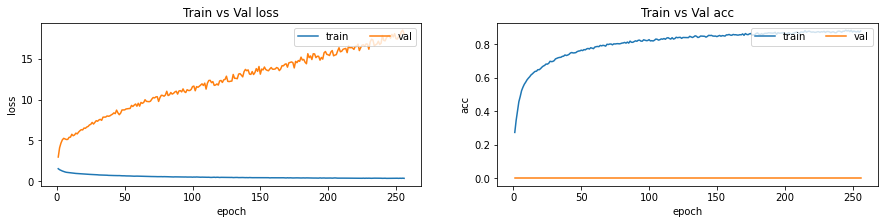

TEST PREDICTION
              precision    recall  f1-score   support

           0       0.44      0.77      0.56       436
           1       0.56      0.66      0.60      1836
           2       0.57      0.82      0.67       862
           3       0.00      0.00      0.00      1555
           4       0.59      0.76      0.66      1750

    accuracy                           0.56      6439
   macro avg       0.43      0.60      0.50      6439
weighted avg       0.42      0.56      0.48      6439



C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
K.clear_session()
epochs = 256
batch_size = 256
gru_units = [24]
dense_units = [12]
spatial_dropout = False #[True, False]
input_dropout = .2#[0.1, 0.15, 0.2, 0.25, 0.3]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance
inter_dropout = .2#


model_hist = []
eval_score = []
loss_score = []
emb_model_ls = {}
model_param_info = {}

us_model = BiGRUAttenGPU(input_dropout = input_dropout, inter_dropout = inter_dropout, 
                         spatial_dropout = spatial_dropout, 
                         gru_units=gru_units, dense_units=dense_units, 
                         has_flatten=False, mask_zero = False) # 81
us_model.summary()
us_hist = us_model.fit(x=train_x, y=train_y, epochs=epochs, batch_size=batch_size,
                                         validation_split=0.2, shuffle=True)
print("EVALUATION")
# this one doesnt have the saved model yet, uses the last 
_, train_acc = us_model.evaluate(train_x, train_y, verbose=0)
# _, val_acc = us_model.evaluate(val_x, val_y, verbose=0)
_, test_acc = us_model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# FITTING PLOT
val_loss = us_hist.history['val_loss'];val_acc = us_hist.history['val_acc']
loss = us_hist.history['loss'];acc = us_hist.history['acc']
make_plot(loss, val_loss, acc, val_acc)

# PREDICTION
print("TEST PREDICTION")
pred = us_model.predict(test_x, verbose=0)
#                             get_predict_metrics(pred, test_y)
# print(cls_report)
pred_y = np.argmax(pred, axis=1)
true_y = np.argmax(test_y, axis=1)
print(classification_report(true_y, pred_y))

Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
_________________________________________________________________
dropout (Dropout)            (None, 65, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 65, 16)            5280      
_________________________________________________________________
attention (Attention)        (None, 16)                81        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 5)               

37/37 [==============================] - 1s 32ms/step - loss: 0.7871 - acc: 0.6989 - val_loss: 6.8789 - val_acc: 0.0000e+00
Epoch 52/256
37/37 [==============================] - 1s 33ms/step - loss: 0.7895 - acc: 0.7003 - val_loss: 6.9677 - val_acc: 0.0000e+00
Epoch 53/256
37/37 [==============================] - 1s 34ms/step - loss: 0.7823 - acc: 0.6993 - val_loss: 6.9451 - val_acc: 0.0000e+00
Epoch 54/256
37/37 [==============================] - 1s 32ms/step - loss: 0.7683 - acc: 0.7094 - val_loss: 6.9792 - val_acc: 0.0000e+00
Epoch 55/256
37/37 [==============================] - 1s 33ms/step - loss: 0.7736 - acc: 0.7070 - val_loss: 6.9869 - val_acc: 0.0000e+00
Epoch 56/256
37/37 [==============================] - 1s 32ms/step - loss: 0.7729 - acc: 0.7054 - val_loss: 6.9670 - val_acc: 0.0000e+00
Epoch 57/256
37/37 [==============================] - 1s 33ms/step - loss: 0.7729 - acc: 0.7050 - val_loss: 7.0321 - val_acc: 0.0000e+00
Epoch 58/256
37/37 [==============================] - 

Epoch 111/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6950 - acc: 0.7361 - val_loss: 8.3822 - val_acc: 0.0000e+00
Epoch 112/256
37/37 [==============================] - 1s 29ms/step - loss: 0.6929 - acc: 0.7384 - val_loss: 8.4244 - val_acc: 0.0000e+00
Epoch 113/256
37/37 [==============================] - 1s 29ms/step - loss: 0.6976 - acc: 0.7371 - val_loss: 8.3657 - val_acc: 0.0000e+00
Epoch 114/256
37/37 [==============================] - 1s 29ms/step - loss: 0.6903 - acc: 0.7420 - val_loss: 8.3762 - val_acc: 0.0000e+00
Epoch 115/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6871 - acc: 0.7402 - val_loss: 8.4825 - val_acc: 0.0000e+00
Epoch 116/256
37/37 [==============================] - 1s 29ms/step - loss: 0.6894 - acc: 0.7421 - val_loss: 8.4982 - val_acc: 0.0000e+00
Epoch 117/256
37/37 [==============================] - 1s 29ms/step - loss: 0.6872 - acc: 0.7414 - val_loss: 8.4202 - val_acc: 0.0000e+00
Epoch 118/256
37/37 [=============

37/37 [==============================] - 1s 28ms/step - loss: 0.6479 - acc: 0.7585 - val_loss: 9.8032 - val_acc: 0.0000e+00
Epoch 171/256
37/37 [==============================] - 1s 29ms/step - loss: 0.6472 - acc: 0.7585 - val_loss: 9.7713 - val_acc: 0.0000e+00
Epoch 172/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6474 - acc: 0.7609 - val_loss: 9.8793 - val_acc: 0.0000e+00
Epoch 173/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6531 - acc: 0.7575 - val_loss: 9.8819 - val_acc: 0.0000e+00
Epoch 174/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6528 - acc: 0.7594 - val_loss: 9.7987 - val_acc: 0.0000e+00
Epoch 175/256
37/37 [==============================] - 1s 29ms/step - loss: 0.6379 - acc: 0.7628 - val_loss: 9.8836 - val_acc: 0.0000e+00
Epoch 176/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6495 - acc: 0.7599 - val_loss: 9.9603 - val_acc: 0.0000e+00
Epoch 177/256
37/37 [===========================

37/37 [==============================] - 1s 28ms/step - loss: 0.6285 - acc: 0.7681 - val_loss: 11.0495 - val_acc: 0.0000e+00
Epoch 230/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6254 - acc: 0.7692 - val_loss: 11.1286 - val_acc: 0.0000e+00
Epoch 231/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6161 - acc: 0.7690 - val_loss: 11.1426 - val_acc: 0.0000e+00
Epoch 232/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6269 - acc: 0.7679 - val_loss: 11.1739 - val_acc: 0.0000e+00
Epoch 233/256
37/37 [==============================] - 1s 27ms/step - loss: 0.6107 - acc: 0.7769 - val_loss: 11.1882 - val_acc: 0.0000e+00
Epoch 234/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6186 - acc: 0.7731 - val_loss: 11.2311 - val_acc: 0.0000e+00
Epoch 235/256
37/37 [==============================] - 1s 28ms/step - loss: 0.6120 - acc: 0.7733 - val_loss: 11.4644 - val_acc: 0.0000e+00
Epoch 236/256
37/37 [====================

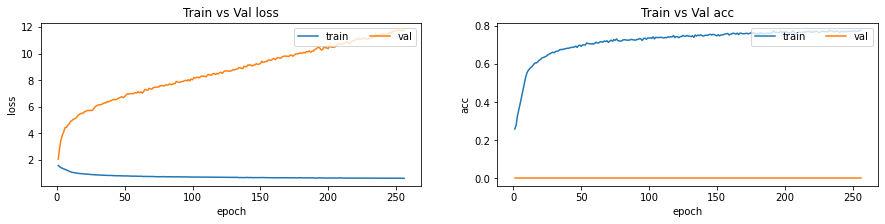

TEST PREDICTION
              precision    recall  f1-score   support

           0       0.48      0.72      0.58       436
           1       0.49      0.74      0.59      1836
           2       0.54      0.78      0.64       862
           3       0.00      0.00      0.00      1555
           4       0.68      0.68      0.68      1750

    accuracy                           0.55      6439
   macro avg       0.44      0.58      0.50      6439
weighted avg       0.43      0.55      0.48      6439



C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
K.clear_session()
epochs = 256
batch_size = 256
gru_units = [8]
dense_units = []
spatial_dropout = False #[True, False]
input_dropout = .2#[0.1, 0.15, 0.2, 0.25, 0.3]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance
inter_dropout = .2#


model_hist = []
eval_score = []
loss_score = []
emb_model_ls = {}
model_param_info = {}

us_model = BiGRUAttenGPU(input_dropout = input_dropout, inter_dropout = inter_dropout, 
                         spatial_dropout = spatial_dropout, 
                         gru_units=gru_units, dense_units=dense_units, 
                         has_flatten=False, mask_zero = False) # 81
us_model.summary()
us_hist = us_model.fit(x=train_x, y=train_y, epochs=epochs, batch_size=batch_size,
                                         validation_split=0.2, shuffle=True)
print("EVALUATION")
# this one doesnt have the saved model yet, uses the last 
_, train_acc = us_model.evaluate(train_x, train_y, verbose=0)
_, test_acc = us_model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# FITTING PLOT
val_loss = us_hist.history['val_loss'];val_acc = us_hist.history['val_acc']
loss = us_hist.history['loss'];acc = us_hist.history['acc']
make_plot(loss, val_loss, acc, val_acc)

# PREDICTION
print("TEST PREDICTION")
pred = us_model.predict(test_x, verbose=0)
#                             get_predict_metrics(pred, test_y)
# print(cls_report)
pred_y = np.argmax(pred, axis=1)
true_y = np.argmax(test_y, axis=1)
print(classification_report(true_y, pred_y))

### LOOP

trainig_start
MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [2] : [] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
_________________________________________________________________
dropout (Dropout)            (None, 65, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 65, 4)             1248      
_________________________________________________________________
attention (Attention)        (None, 4)                 69        
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_

Epoch 109/256
37/37 [==============================] - 0s 12ms/step - loss: 1.0615 - acc: 0.5330 - val_loss: 5.0659 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 0s 12ms/step - loss: 1.0671 - acc: 0.5305 - val_loss: 5.0246 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [==============================] - 0s 12ms/step - loss: 1.0633 - acc: 0.5334 - val_loss: 5.0623 - val_acc: 0.0000e+00
Epoch 112/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0655 - acc: 0.5217 - val_loss: 5.0748 - val_acc: 0.0000e+00
Epoch 113/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0666 - acc: 0.5236 - val_loss: 5.0685 - val_acc: 0.0000e+00
Epoch 114/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0592 - acc: 0.5326 - val_loss: 5.1018 - val_acc: 0.0000e+00
Epoch 115/256
37/37 [==============================] - 1s 14ms/step - loss: 1.0582 - acc: 0.5280 - val_loss: 5.1131 - val_acc: 0.0000e+00
Epoch 116/256
37/37 [=============

37/37 [==============================] - 0s 13ms/step - loss: 1.0321 - acc: 0.5450 - val_loss: 6.7248 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - 1s 16ms/step - loss: 1.0325 - acc: 0.5537 - val_loss: 6.7811 - val_acc: 0.0000e+00
Epoch 229/256
37/37 [==============================] - 1s 18ms/step - loss: 1.0354 - acc: 0.5451 - val_loss: 6.7802 - val_acc: 0.0000e+00
Epoch 230/256
37/37 [==============================] - 1s 14ms/step - loss: 1.0359 - acc: 0.5422 - val_loss: 6.8031 - val_acc: 0.0000e+00
Epoch 231/256
37/37 [==============================] - 1s 14ms/step - loss: 1.0474 - acc: 0.5401 - val_loss: 6.8030 - val_acc: 0.0000e+00
Epoch 232/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0390 - acc: 0.5500 - val_loss: 6.8426 - val_acc: 0.0000e+00
Epoch 233/256
37/37 [==============================] - 0s 12ms/step - loss: 1.0440 - acc: 0.5423 - val_loss: 6.8399 - val_acc: 0.0000e+00
Epoch 234/256
37/37 [===========================

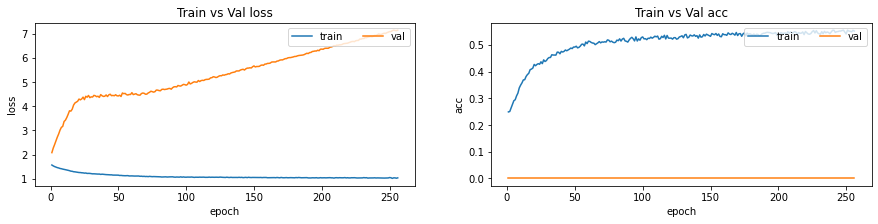

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.41      0.58      0.48       436
           1       0.41      0.69      0.51      1836
           2       0.52      0.72      0.60       862
           3       0.00      0.00      0.00      1555
           4       0.62      0.53      0.57      1750

    accuracy                           0.48      6439
   macro avg       0.39      0.51      0.43      6439
weighted avg       0.38      0.48      0.42      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [2] : [4] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
_____________________________________________________

Epoch 104/256
37/37 [==============================] - 1s 14ms/step - loss: 1.2362 - acc: 0.3957 - val_loss: 7.3033 - val_acc: 0.0000e+00
Epoch 105/256
37/37 [==============================] - 0s 13ms/step - loss: 1.2329 - acc: 0.3954 - val_loss: 7.4992 - val_acc: 0.0000e+00
Epoch 106/256
37/37 [==============================] - 1s 14ms/step - loss: 1.2289 - acc: 0.4043 - val_loss: 7.1868 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 1s 14ms/step - loss: 1.2217 - acc: 0.4045 - val_loss: 7.6240 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 1s 14ms/step - loss: 1.2318 - acc: 0.4066 - val_loss: 7.4755 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 0s 13ms/step - loss: 1.2281 - acc: 0.4033 - val_loss: 7.4090 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 1s 14ms/step - loss: 1.2249 - acc: 0.4034 - val_loss: 7.3585 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [=============

37/37 [==============================] - 1s 16ms/step - loss: 1.1903 - acc: 0.4357 - val_loss: 8.2685 - val_acc: 0.0000e+00
Epoch 223/256
37/37 [==============================] - 1s 16ms/step - loss: 1.1966 - acc: 0.4307 - val_loss: 8.2447 - val_acc: 0.0000e+00
Epoch 224/256
37/37 [==============================] - 1s 17ms/step - loss: 1.1874 - acc: 0.4348 - val_loss: 8.2273 - val_acc: 0.0000e+00
Epoch 225/256
37/37 [==============================] - 1s 15ms/step - loss: 1.1954 - acc: 0.4273 - val_loss: 8.1947 - val_acc: 0.0000e+00
Epoch 226/256
37/37 [==============================] - 1s 23ms/step - loss: 1.1840 - acc: 0.4384 - val_loss: 8.2135 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 1s 22ms/step - loss: 1.1852 - acc: 0.4427 - val_loss: 8.0333 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - 1s 23ms/step - loss: 1.1913 - acc: 0.4388 - val_loss: 8.1575 - val_acc: 0.0000e+00
Epoch 229/256
37/37 [===========================

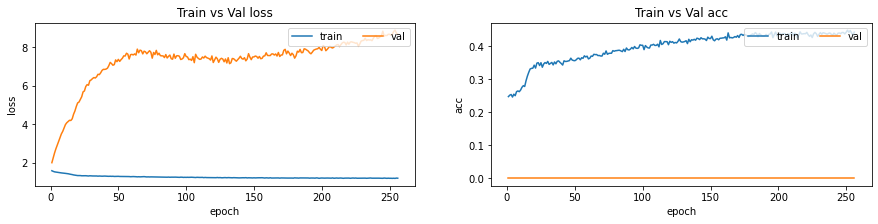

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.34      0.56      0.42       436
           1       0.34      0.13      0.19      1836
           2       0.37      0.80      0.51       862
           3       0.00      0.00      0.00      1555
           4       0.35      0.63      0.45      1750

    accuracy                           0.35      6439
   macro avg       0.28      0.42      0.31      6439
weighted avg       0.26      0.35      0.27      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [2] : [6] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
_____________________________________________________

Epoch 104/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1818 - acc: 0.4494 - val_loss: 6.2313 - val_acc: 0.0000e+00
Epoch 105/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1888 - acc: 0.4386 - val_loss: 6.2289 - val_acc: 0.0000e+00
Epoch 106/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1896 - acc: 0.4342 - val_loss: 6.2062 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1746 - acc: 0.4542 - val_loss: 6.2887 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1848 - acc: 0.4488 - val_loss: 6.3113 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1853 - acc: 0.4409 - val_loss: 6.2776 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 1s 15ms/step - loss: 1.1884 - acc: 0.4430 - val_loss: 6.2769 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [=============

37/37 [==============================] - 1s 15ms/step - loss: 1.1644 - acc: 0.4491 - val_loss: 7.2831 - val_acc: 0.0000e+00
Epoch 164/256
37/37 [==============================] - 1s 15ms/step - loss: 1.1570 - acc: 0.4603 - val_loss: 7.3453 - val_acc: 0.0000e+00
Epoch 165/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1659 - acc: 0.4489 - val_loss: 7.2979 - val_acc: 0.0000e+00
Epoch 166/256
37/37 [==============================] - 1s 15ms/step - loss: 1.1571 - acc: 0.4575 - val_loss: 7.3685 - val_acc: 0.0000e+00
Epoch 167/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1602 - acc: 0.4547 - val_loss: 7.3831 - val_acc: 0.0000e+00
Epoch 168/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1565 - acc: 0.4538 - val_loss: 7.4007 - val_acc: 0.0000e+00
Epoch 169/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1636 - acc: 0.4491 - val_loss: 7.4098 - val_acc: 0.0000e+00
Epoch 170/256
37/37 [===========================

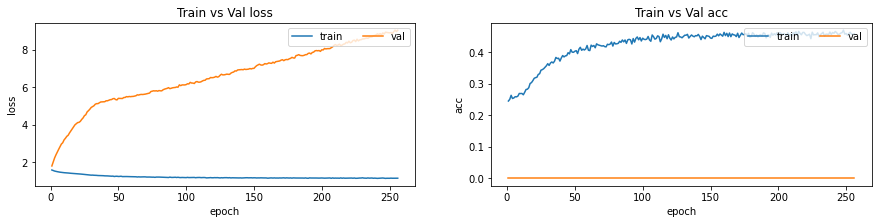

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      0.59      0.54       436
           1       0.34      0.18      0.23      1836
           2       0.47      0.73      0.57       862
           3       0.00      0.00      0.00      1555
           4       0.38      0.79      0.51      1750

    accuracy                           0.40      6439
   macro avg       0.34      0.46      0.37      6439
weighted avg       0.30      0.40      0.32      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [4] : [] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
______________________________________________________

Epoch 106/256
37/37 [==============================] - 1s 14ms/step - loss: 0.9341 - acc: 0.6190 - val_loss: 6.2569 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 1s 14ms/step - loss: 0.9382 - acc: 0.6178 - val_loss: 6.2662 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 0s 13ms/step - loss: 0.9438 - acc: 0.6144 - val_loss: 6.2869 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 1s 15ms/step - loss: 0.9453 - acc: 0.6202 - val_loss: 6.2871 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 1s 17ms/step - loss: 0.9469 - acc: 0.6129 - val_loss: 6.3102 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [==============================] - 1s 18ms/step - loss: 0.9325 - acc: 0.6242 - val_loss: 6.3384 - val_acc: 0.0000e+00
Epoch 112/256
37/37 [==============================] - 1s 16ms/step - loss: 0.9375 - acc: 0.6166 - val_loss: 6.3699 - val_acc: 0.0000e+00
Epoch 113/256
37/37 [=============

37/37 [==============================] - 1s 15ms/step - loss: 0.8953 - acc: 0.6420 - val_loss: 7.8517 - val_acc: 0.0000e+00
Epoch 225/256
37/37 [==============================] - 1s 15ms/step - loss: 0.8955 - acc: 0.6387 - val_loss: 7.9028 - val_acc: 0.0000e+00
Epoch 226/256
37/37 [==============================] - 1s 16ms/step - loss: 0.8905 - acc: 0.6421 - val_loss: 7.9065 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 1s 15ms/step - loss: 0.9013 - acc: 0.6382 - val_loss: 7.8902 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - 1s 14ms/step - loss: 0.8972 - acc: 0.6412 - val_loss: 7.8814 - val_acc: 0.0000e+00
Epoch 229/256
37/37 [==============================] - 0s 13ms/step - loss: 0.8910 - acc: 0.6358 - val_loss: 7.8953 - val_acc: 0.0000e+00
Epoch 230/256
37/37 [==============================] - 1s 14ms/step - loss: 0.8945 - acc: 0.6378 - val_loss: 7.9119 - val_acc: 0.0000e+00
Epoch 231/256
37/37 [===========================

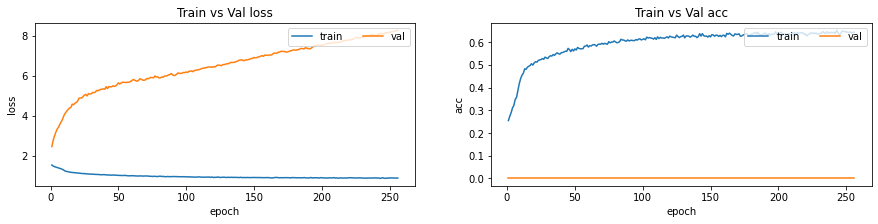

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.46      0.63      0.53       436
           1       0.45      0.69      0.54      1836
           2       0.51      0.77      0.61       862
           3       0.00      0.00      0.00      1555
           4       0.64      0.62      0.63      1750

    accuracy                           0.51      6439
   macro avg       0.41      0.54      0.46      6439
weighted avg       0.40      0.51      0.44      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [4] : [4] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
_____________________________________________________

Epoch 104/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1468 - acc: 0.4742 - val_loss: 6.5141 - val_acc: 0.0000e+00
Epoch 105/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1449 - acc: 0.4645 - val_loss: 6.5624 - val_acc: 0.0000e+00
Epoch 106/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1537 - acc: 0.4719 - val_loss: 6.5606 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1480 - acc: 0.4625 - val_loss: 6.5836 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1500 - acc: 0.4754 - val_loss: 6.6251 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1439 - acc: 0.4728 - val_loss: 6.5621 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1511 - acc: 0.4680 - val_loss: 6.5685 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [=============

37/37 [==============================] - 0s 13ms/step - loss: 1.1226 - acc: 0.4929 - val_loss: 8.2118 - val_acc: 0.0000e+00
Epoch 223/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1164 - acc: 0.4942 - val_loss: 8.3370 - val_acc: 0.0000e+00
Epoch 224/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1161 - acc: 0.4942 - val_loss: 8.3150 - val_acc: 0.0000e+00
Epoch 225/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1263 - acc: 0.4874 - val_loss: 8.1424 - val_acc: 0.0000e+00
Epoch 226/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1221 - acc: 0.4922 - val_loss: 8.2695 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1168 - acc: 0.4966 - val_loss: 8.2239 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1204 - acc: 0.4915 - val_loss: 8.2708 - val_acc: 0.0000e+00
Epoch 229/256
37/37 [===========================

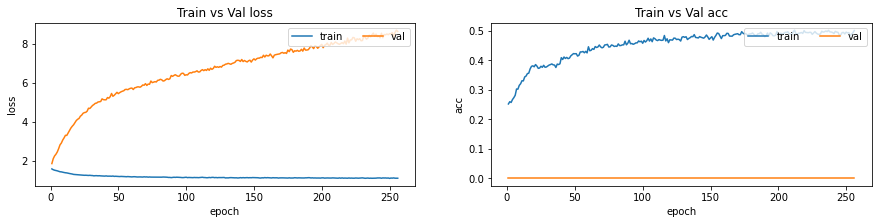

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.46      0.64      0.54       436
           1       0.31      0.09      0.15      1836
           2       0.52      0.73      0.61       862
           3       0.00      0.00      0.00      1555
           4       0.34      0.80      0.48      1750

    accuracy                           0.39      6439
   macro avg       0.33      0.45      0.35      6439
weighted avg       0.28      0.39      0.29      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [4] : [6] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
_____________________________________________________

Epoch 104/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1053 - acc: 0.5205 - val_loss: 8.1292 - val_acc: 0.0000e+00
Epoch 105/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1051 - acc: 0.5218 - val_loss: 8.4776 - val_acc: 0.0000e+00
Epoch 106/256
37/37 [==============================] - 0s 13ms/step - loss: 1.1027 - acc: 0.5257 - val_loss: 8.1147 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0993 - acc: 0.5213 - val_loss: 8.5740 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0955 - acc: 0.5241 - val_loss: 8.3805 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0999 - acc: 0.5276 - val_loss: 8.4701 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0949 - acc: 0.5251 - val_loss: 8.1280 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [=============

Epoch 222/256
37/37 [==============================] - 1s 14ms/step - loss: 1.0627 - acc: 0.5387 - val_loss: 10.5959 - val_acc: 0.0000e+00
Epoch 223/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0564 - acc: 0.5452 - val_loss: 11.2000 - val_acc: 0.0000e+00
Epoch 224/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0611 - acc: 0.5349 - val_loss: 11.1354 - val_acc: 0.0000e+00
Epoch 225/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0621 - acc: 0.5429 - val_loss: 11.1616 - val_acc: 0.0000e+00
Epoch 226/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0594 - acc: 0.5484 - val_loss: 11.0183 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0633 - acc: 0.5468 - val_loss: 11.2041 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - ETA: 0s - loss: 1.0631 - acc: 0.543 - 1s 14ms/step - loss: 1.0614 - acc: 0.5450 - val_loss: 11.0592 - val_acc: 

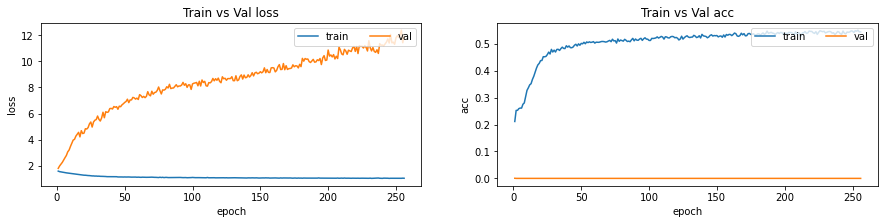

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.35      0.78      0.48       436
           1       0.39      0.30      0.33      1836
           2       0.48      0.75      0.59       862
           3       0.00      0.00      0.00      1555
           4       0.44      0.68      0.54      1750

    accuracy                           0.42      6439
   macro avg       0.33      0.50      0.39      6439
weighted avg       0.32      0.42      0.35      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [8] : [] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
______________________________________________________

Epoch 106/256
37/37 [==============================] - 0s 13ms/step - loss: 0.7630 - acc: 0.7214 - val_loss: 6.9768 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 0s 13ms/step - loss: 0.7751 - acc: 0.7147 - val_loss: 6.7570 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 1s 15ms/step - loss: 0.7614 - acc: 0.7217 - val_loss: 6.8874 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 1s 15ms/step - loss: 0.7672 - acc: 0.7165 - val_loss: 6.8962 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 0s 13ms/step - loss: 0.7702 - acc: 0.7189 - val_loss: 6.9900 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [==============================] - 0s 13ms/step - loss: 0.7624 - acc: 0.7184 - val_loss: 6.8547 - val_acc: 0.0000e+00
Epoch 112/256
37/37 [==============================] - 1s 15ms/step - loss: 0.7605 - acc: 0.7236 - val_loss: 6.9593 - val_acc: 0.0000e+00
Epoch 113/256
37/37 [=============

37/37 [==============================] - 1s 15ms/step - loss: 0.6986 - acc: 0.7503 - val_loss: 8.3056 - val_acc: 0.0000e+00
Epoch 225/256
37/37 [==============================] - 1s 15ms/step - loss: 0.6968 - acc: 0.7451 - val_loss: 8.2413 - val_acc: 0.0000e+00
Epoch 226/256
37/37 [==============================] - 1s 15ms/step - loss: 0.7019 - acc: 0.7449 - val_loss: 8.3187 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 1s 14ms/step - loss: 0.6899 - acc: 0.7522 - val_loss: 8.2744 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - 1s 14ms/step - loss: 0.6928 - acc: 0.7469 - val_loss: 8.2720 - val_acc: 0.0000e+00
Epoch 229/256
37/37 [==============================] - 1s 14ms/step - loss: 0.7066 - acc: 0.7468 - val_loss: 8.3158 - val_acc: 0.0000e+00
Epoch 230/256
37/37 [==============================] - 1s 14ms/step - loss: 0.6996 - acc: 0.7432 - val_loss: 8.2213 - val_acc: 0.0000e+00
Epoch 231/256
37/37 [===========================

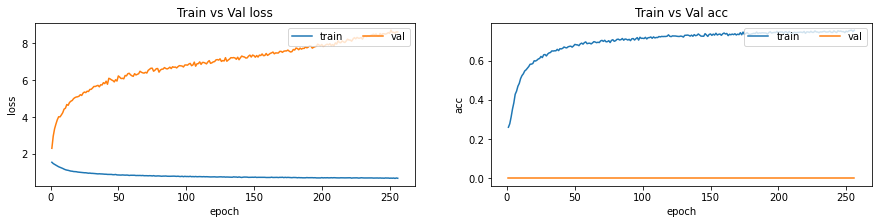

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.42      0.75      0.54       436
           1       0.51      0.67      0.58      1836
           2       0.51      0.77      0.62       862
           3       0.00      0.00      0.00      1555
           4       0.63      0.71      0.67      1750

    accuracy                           0.54      6439
   macro avg       0.42      0.58      0.48      6439
weighted avg       0.41      0.54      0.47      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [8] : [4] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
_____________________________________________________

Epoch 44/256
37/37 [==============================] - 1s 20ms/step - loss: 1.2239 - acc: 0.4174 - val_loss: 4.8078 - val_acc: 0.0000e+00
Epoch 45/256
37/37 [==============================] - 1s 17ms/step - loss: 1.2154 - acc: 0.4267 - val_loss: 4.8759 - val_acc: 0.0000e+00
Epoch 46/256
37/37 [==============================] - 1s 18ms/step - loss: 1.2097 - acc: 0.4226 - val_loss: 4.9468 - val_acc: 0.0000e+00
Epoch 47/256
37/37 [==============================] - 1s 17ms/step - loss: 1.2030 - acc: 0.4351 - val_loss: 5.0491 - val_acc: 0.0000e+00
Epoch 48/256
37/37 [==============================] - 1s 19ms/step - loss: 1.2027 - acc: 0.4274 - val_loss: 5.0375 - val_acc: 0.0000e+00
Epoch 49/256
37/37 [==============================] - 1s 17ms/step - loss: 1.1989 - acc: 0.4386 - val_loss: 5.0397 - val_acc: 0.0000e+00
Epoch 50/256
37/37 [==============================] - 1s 16ms/step - loss: 1.2054 - acc: 0.4404 - val_loss: 5.0697 - val_acc: 0.0000e+00
Epoch 51/256
37/37 [=====================

Epoch 104/256
37/37 [==============================] - 1s 15ms/step - loss: 1.1228 - acc: 0.5171 - val_loss: 6.6422 - val_acc: 0.0000e+00
Epoch 105/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1261 - acc: 0.5068 - val_loss: 6.6553 - val_acc: 0.0000e+00
Epoch 106/256
37/37 [==============================] - 1s 15ms/step - loss: 1.1269 - acc: 0.5152 - val_loss: 6.6701 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 1s 16ms/step - loss: 1.1121 - acc: 0.5250 - val_loss: 6.7455 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 1s 15ms/step - loss: 1.1153 - acc: 0.5132 - val_loss: 6.6510 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 1s 14ms/step - loss: 1.1151 - acc: 0.5264 - val_loss: 6.8228 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 1s 16ms/step - loss: 1.1130 - acc: 0.5185 - val_loss: 6.9913 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [=============

37/37 [==============================] - 0s 13ms/step - loss: 1.0729 - acc: 0.5562 - val_loss: 9.3875 - val_acc: 0.0000e+00
Epoch 223/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0757 - acc: 0.5484 - val_loss: 9.9835 - val_acc: 0.0000e+00
Epoch 224/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0615 - acc: 0.5620 - val_loss: 10.0214 - val_acc: 0.0000e+00
Epoch 225/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0579 - acc: 0.5607 - val_loss: 9.9210 - val_acc: 0.0000e+00
Epoch 226/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0678 - acc: 0.5554 - val_loss: 9.8035 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0701 - acc: 0.5513 - val_loss: 10.4878 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - 0s 13ms/step - loss: 1.0625 - acc: 0.5607 - val_loss: 10.0166 - val_acc: 0.0000e+00
Epoch 229/256
37/37 [========================

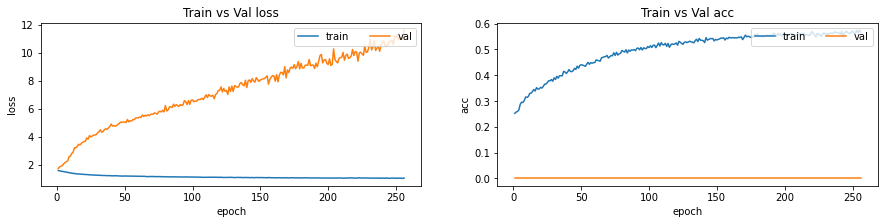

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.39      0.73      0.50       436
           1       0.41      0.49      0.45      1836
           2       0.56      0.77      0.65       862
           3       0.00      0.00      0.00      1555
           4       0.53      0.67      0.59      1750

    accuracy                           0.47      6439
   macro avg       0.38      0.53      0.44      6439
weighted avg       0.36      0.47      0.41      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [8] : [6] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
_____________________________________________________

Epoch 104/256
37/37 [==============================] - 1s 14ms/step - loss: 1.0284 - acc: 0.5355 - val_loss: 8.0150 - val_acc: 0.0000e+00
Epoch 105/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0345 - acc: 0.5308 - val_loss: 8.0800 - val_acc: 0.0000e+00
Epoch 106/256
37/37 [==============================] - 1s 14ms/step - loss: 1.0322 - acc: 0.5312 - val_loss: 7.8179 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0245 - acc: 0.5303 - val_loss: 8.3111 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0332 - acc: 0.5311 - val_loss: 8.0129 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0320 - acc: 0.5317 - val_loss: 8.1007 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0304 - acc: 0.5302 - val_loss: 8.2627 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [=============

37/37 [==============================] - 1s 14ms/step - loss: 0.9843 - acc: 0.5567 - val_loss: 10.4283 - val_acc: 0.0000e+00
Epoch 223/256
37/37 [==============================] - 1s 14ms/step - loss: 0.9750 - acc: 0.5600 - val_loss: 10.2862 - val_acc: 0.0000e+00
Epoch 224/256
37/37 [==============================] - 1s 14ms/step - loss: 0.9686 - acc: 0.5633 - val_loss: 10.8624 - val_acc: 0.0000e+00
Epoch 225/256
37/37 [==============================] - 0s 13ms/step - loss: 0.9797 - acc: 0.5576 - val_loss: 10.5711 - val_acc: 0.0000e+00
Epoch 226/256
37/37 [==============================] - 0s 13ms/step - loss: 0.9807 - acc: 0.5601 - val_loss: 10.6957 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 1s 14ms/step - loss: 0.9851 - acc: 0.5598 - val_loss: 10.4683 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - 0s 13ms/step - loss: 0.9772 - acc: 0.5577 - val_loss: 10.8503 - val_acc: 0.0000e+00
Epoch 229/256
37/37 [====================

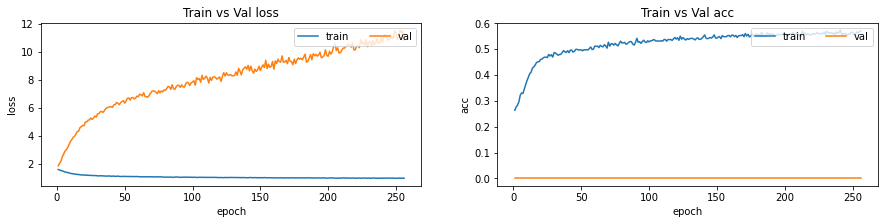

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.35      0.76      0.48       436
           1       0.40      0.46      0.43      1836
           2       0.45      0.78      0.57       862
           3       0.00      0.00      0.00      1555
           4       0.56      0.61      0.58      1750

    accuracy                           0.45      6439
   macro avg       0.35      0.52      0.41      6439
weighted avg       0.35      0.45      0.39      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [16] : [] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
_____________________________________________________

Epoch 46/256
37/37 [==============================] - 1s 16ms/step - loss: 0.7683 - acc: 0.7086 - val_loss: 7.6519 - val_acc: 0.0000e+00
Epoch 47/256
37/37 [==============================] - 1s 15ms/step - loss: 0.7617 - acc: 0.7128 - val_loss: 7.6720 - val_acc: 0.0000e+00
Epoch 48/256
37/37 [==============================] - 1s 15ms/step - loss: 0.7573 - acc: 0.7109 - val_loss: 7.6112 - val_acc: 0.0000e+00
Epoch 49/256
37/37 [==============================] - 1s 14ms/step - loss: 0.7463 - acc: 0.7188 - val_loss: 7.7829 - val_acc: 0.0000e+00
Epoch 50/256
37/37 [==============================] - 1s 15ms/step - loss: 0.7506 - acc: 0.7149 - val_loss: 7.6915 - val_acc: 0.0000e+00
Epoch 51/256
37/37 [==============================] - 1s 15ms/step - loss: 0.7490 - acc: 0.7228 - val_loss: 7.8083 - val_acc: 0.0000e+00
Epoch 52/256
37/37 [==============================] - 1s 14ms/step - loss: 0.7448 - acc: 0.7195 - val_loss: 7.7575 - val_acc: 0.0000e+00
Epoch 53/256
37/37 [=====================

Epoch 106/256
37/37 [==============================] - 1s 16ms/step - loss: 0.6173 - acc: 0.7712 - val_loss: 9.0576 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 1s 16ms/step - loss: 0.6265 - acc: 0.7737 - val_loss: 9.1785 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 1s 16ms/step - loss: 0.6222 - acc: 0.7751 - val_loss: 9.1373 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 1s 15ms/step - loss: 0.6211 - acc: 0.7720 - val_loss: 9.2185 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 1s 15ms/step - loss: 0.6182 - acc: 0.7735 - val_loss: 9.2965 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [==============================] - 1s 15ms/step - loss: 0.6065 - acc: 0.7837 - val_loss: 9.2619 - val_acc: 0.0000e+00
Epoch 112/256
37/37 [==============================] - 1s 15ms/step - loss: 0.6100 - acc: 0.7795 - val_loss: 9.3564 - val_acc: 0.0000e+00
Epoch 113/256
37/37 [=============

37/37 [==============================] - 1s 18ms/step - loss: 0.5257 - acc: 0.8131 - val_loss: 11.1787 - val_acc: 0.0000e+00
Epoch 225/256
37/37 [==============================] - 1s 16ms/step - loss: 0.5174 - acc: 0.8161 - val_loss: 11.0721 - val_acc: 0.0000e+00
Epoch 226/256
37/37 [==============================] - 1s 17ms/step - loss: 0.5130 - acc: 0.8179 - val_loss: 11.0574 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 1s 16ms/step - loss: 0.5196 - acc: 0.8104 - val_loss: 11.1209 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - 1s 14ms/step - loss: 0.5258 - acc: 0.8144 - val_loss: 10.9659 - val_acc: 0.0000e+00
Epoch 229/256
37/37 [==============================] - 1s 14ms/step - loss: 0.5143 - acc: 0.8125 - val_loss: 11.0261 - val_acc: 0.0000e+00
Epoch 230/256
37/37 [==============================] - 1s 14ms/step - loss: 0.5169 - acc: 0.8145 - val_loss: 11.0912 - val_acc: 0.0000e+00
Epoch 231/256
37/37 [====================

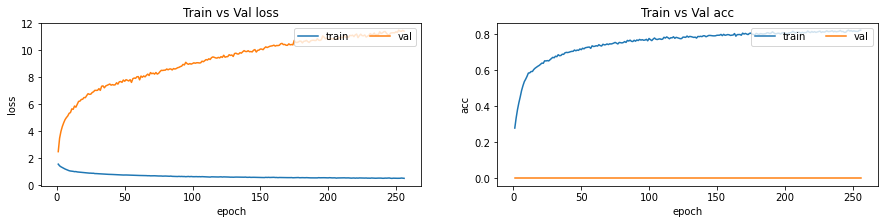

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.48      0.73      0.58       436
           1       0.56      0.66      0.61      1836
           2       0.50      0.85      0.63       862
           3       0.00      0.00      0.00      1555
           4       0.61      0.76      0.68      1750

    accuracy                           0.56      6439
   macro avg       0.43      0.60      0.50      6439
weighted avg       0.43      0.56      0.48      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [16] : [4] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
____________________________________________________

Epoch 104/256
37/37 [==============================] - 1s 14ms/step - loss: 1.0406 - acc: 0.5518 - val_loss: 7.0457 - val_acc: 0.0000e+00
Epoch 105/256
37/37 [==============================] - 1s 14ms/step - loss: 1.0297 - acc: 0.5550 - val_loss: 7.0104 - val_acc: 0.0000e+00
Epoch 106/256
37/37 [==============================] - 1s 14ms/step - loss: 1.0541 - acc: 0.5554 - val_loss: 6.5434 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0257 - acc: 0.5584 - val_loss: 7.1824 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0466 - acc: 0.5497 - val_loss: 8.2964 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 1s 15ms/step - loss: 1.0277 - acc: 0.5586 - val_loss: 8.6132 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [==============================] - 1s 14ms/step - loss: 1.0309 - acc: 0.5524 - val_loss: 8.7006 - val_acc: 0.0000e+00
Epoch 111/256
37/37 [=============

37/37 [==============================] - 1s 15ms/step - loss: 0.9497 - acc: 0.5972 - val_loss: 11.7656 - val_acc: 0.0000e+00
Epoch 223/256
37/37 [==============================] - 1s 15ms/step - loss: 0.9557 - acc: 0.5950 - val_loss: 11.4997 - val_acc: 0.0000e+00
Epoch 224/256
37/37 [==============================] - 1s 14ms/step - loss: 0.9451 - acc: 0.6108 - val_loss: 10.8244 - val_acc: 0.0000e+00
Epoch 225/256
37/37 [==============================] - 1s 18ms/step - loss: 0.9602 - acc: 0.5973 - val_loss: 12.8006 - val_acc: 0.0000e+00
Epoch 226/256
37/37 [==============================] - 1s 15ms/step - loss: 0.9555 - acc: 0.5951 - val_loss: 11.9666 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 1s 16ms/step - loss: 0.9531 - acc: 0.5932 - val_loss: 12.4135 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [==============================] - 1s 17ms/step - loss: 0.9786 - acc: 0.5814 - val_loss: 11.0102 - val_acc: 0.0000e+00
Epoch 229/256
37/37 [====================

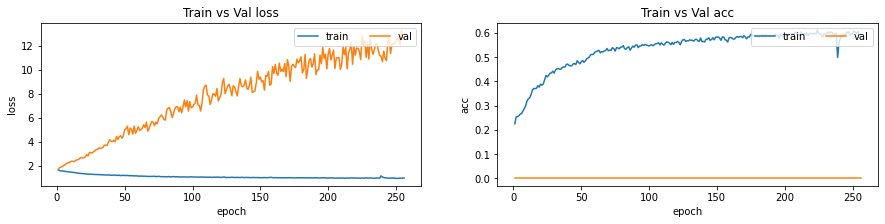

TEST PREDICTION


C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.53      0.63      0.57       436
           1       0.38      0.59      0.46      1836
           2       0.42      0.86      0.57       862
           3       0.00      0.00      0.00      1555
           4       0.56      0.42      0.48      1750

    accuracy                           0.44      6439
   macro avg       0.38      0.50      0.42      6439
weighted avg       0.35      0.44      0.38      6439

MODEL START
emb_size : batch_size : gu : du : sd : inpd : intd
100 : 256 : [16] : [6] : False : 0.2 : 0.5
Model: "BiGRUAttenGPU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 65, 100)           2147300   
____________________________________________________

37/37 [==============================] - 1s 14ms/step - loss: 0.9503 - acc: 0.6047 - val_loss: 11.2671 - val_acc: 0.0000e+00
Epoch 104/256
37/37 [==============================] - 1s 14ms/step - loss: 0.9417 - acc: 0.6110 - val_loss: 11.8495 - val_acc: 0.0000e+00
Epoch 105/256
37/37 [==============================] - 1s 15ms/step - loss: 0.9508 - acc: 0.6077 - val_loss: 11.7255 - val_acc: 0.0000e+00
Epoch 106/256
37/37 [==============================] - 1s 16ms/step - loss: 0.9430 - acc: 0.6044 - val_loss: 11.5202 - val_acc: 0.0000e+00
Epoch 107/256
37/37 [==============================] - 1s 16ms/step - loss: 0.9407 - acc: 0.5993 - val_loss: 13.3625 - val_acc: 0.0000e+00
Epoch 108/256
37/37 [==============================] - 1s 16ms/step - loss: 0.9221 - acc: 0.6136 - val_loss: 12.4766 - val_acc: 0.0000e+00
Epoch 109/256
37/37 [==============================] - 1s 16ms/step - loss: 0.9595 - acc: 0.5959 - val_loss: 10.5773 - val_acc: 0.0000e+00
Epoch 110/256
37/37 [====================

37/37 [==============================] - 1s 15ms/step - loss: 0.9032 - acc: 0.6288 - val_loss: 14.1334 - val_acc: 0.0000e+00
Epoch 163/256
37/37 [==============================] - 1s 16ms/step - loss: 0.8901 - acc: 0.6320 - val_loss: 14.9501 - val_acc: 0.0000e+00
Epoch 164/256
37/37 [==============================] - 1s 16ms/step - loss: 0.8983 - acc: 0.6346 - val_loss: 13.4138 - val_acc: 0.0000e+00
Epoch 165/256
37/37 [==============================] - 1s 17ms/step - loss: 0.9011 - acc: 0.6283 - val_loss: 14.4385 - val_acc: 0.0000e+00
Epoch 166/256
37/37 [==============================] - 1s 16ms/step - loss: 0.8938 - acc: 0.6351 - val_loss: 14.2527 - val_acc: 0.0000e+00
Epoch 167/256
37/37 [==============================] - 1s 16ms/step - loss: 0.8912 - acc: 0.6296 - val_loss: 13.3375 - val_acc: 0.0000e+00
Epoch 168/256
37/37 [==============================] - 1s 14ms/step - loss: 0.8942 - acc: 0.6322 - val_loss: 14.1889 - val_acc: 0.0000e+00
Epoch 169/256
37/37 [====================

37/37 [==============================] - 1s 15ms/step - loss: 0.8787 - acc: 0.6380 - val_loss: 16.1104 - val_acc: 0.0000e+00
Epoch 222/256
37/37 [==============================] - 1s 15ms/step - loss: 0.8538 - acc: 0.6513 - val_loss: 15.6074 - val_acc: 0.0000e+00
Epoch 223/256
37/37 [==============================] - 1s 15ms/step - loss: 0.8592 - acc: 0.6478 - val_loss: 16.2859 - val_acc: 0.0000e+00
Epoch 224/256
37/37 [==============================] - 1s 15ms/step - loss: 0.8634 - acc: 0.6432 - val_loss: 15.9005 - val_acc: 0.0000e+00
Epoch 225/256
37/37 [==============================] - 1s 15ms/step - loss: 0.8660 - acc: 0.6371 - val_loss: 16.2644 - val_acc: 0.0000e+00
Epoch 226/256
37/37 [==============================] - 1s 15ms/step - loss: 0.8547 - acc: 0.6486 - val_loss: 16.4033 - val_acc: 0.0000e+00
Epoch 227/256
37/37 [==============================] - 1s 15ms/step - loss: 0.8547 - acc: 0.6452 - val_loss: 16.1398 - val_acc: 0.0000e+00
Epoch 228/256
37/37 [====================

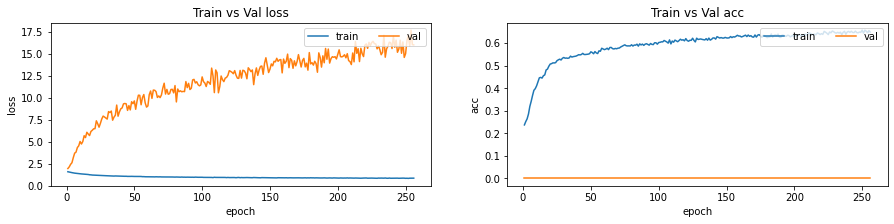

TEST PREDICTION
              precision    recall  f1-score   support

           0       0.50      0.68      0.58       436
           1       0.40      0.37      0.38      1836
           2       0.48      0.87      0.62       862
           3       0.00      0.00      0.00      1555
           4       0.48      0.70      0.57      1750

    accuracy                           0.46      6439
   macro avg       0.37      0.52      0.43      6439
weighted avg       0.34      0.46      0.39      6439



C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
# %%time
"""
at 64 gru unit its already overfitting

32 gru + 16 dense,== 32 gru + 32 dense => 72% with good fit
"""


#  hyperparameters
# gru_units = [[16], [32], [64]]# [16,16], [32,32]]
# dense_units = [[8], [16], [32]]# [8,8], [16,16]]
# spatial_dropout = [False] #[True, False]
# input_dropout = [0.2]#[0.1, 0.15, 0.2, 0.25, 0.3]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance
# inter_dropout = [0.2]#[0.2, 0.3, 0.5, 0.7, 0.9, 1]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance

# gru_units = [[16,16], [32,32]]
# dense_units = [[16], [32]]# [8,8], [16,16]]
# spatial_dropout = [False] #[True, False]
# input_dropout = [0.2]#[0.1, 0.15, 0.2, 0.25, 0.3]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance
# inter_dropout = [0.2]#[0.2, 0.3, 0.5, 0.7, 0.9, 1]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance

gru_units = [[2],[4],[8],[16]]
dense_units = [[],[4],[6]]#[[16], [32]]# [8,8], [16,16]]
spatial_dropout = [False] #[True, False]
input_dropout = [0.2]#[0.1, 0.15, 0.2, 0.25, 0.3]#, 0.25, 0.3, 0.4, 0.5, 1] # 1 = no dropout # 0.2 has better performance
inter_dropout = [0.5]#

# save scores
model_hist = []
eval_score = []
loss_score = []
emb_model_ls = {}
model_param_info = {}
# Train on 16729 samples, validate on 2091 samples
epochs = 256 # 300 # 1000 # 60 is usually where it starts to overlap

# hyper parameter tuning loop, since keras-tuner is having a problem with the dependencies
# emb_file = ["../data/glove.twitter.27B.25d.txt","../data/glove.twitter.27B.50d.txt"]
# emb_size = [25, 50]
print("trainig_start")

# for emb_size, embedding_matrix in zip(emb_size_ls, embedding_matrix_ls): # [1] = 100D, [0] = 50D
for batch_size in [256]: # 256 best performance
    for gu in gru_units:
        for du in dense_units:
            for sd in spatial_dropout:
                for inpd in input_dropout:
                    for intd in inter_dropout:
                        print("================================================================")
                        print("================================================================")
                        print("MODEL START")
                        print(f"emb_size : batch_size : gu : du : sd : inpd : intd")
                        print(f"{emb_size} : {batch_size} : {gu} : {du} : {sd} : {inpd} : {intd}")
                        K.clear_session()
                        # TRAINING
                    #     model = BiGRUAttenGPU(mask_zero = True, spatial_dropout = False, gru_units=64) # 80
                    #     model = BiGRUAtten()
                    #     model = BiGRUAttenGPU(mask_zero = False, spatial_dropout = False, gru_units=64, has_capsule=True) # 81
                    #     model = RathnayakaModel()
                    #     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
                        model = BiGRUAttenGPU(input_dropout = inpd, inter_dropout = intd, spatial_dropout = sd, gru_units=gu, dense_units=du, has_flatten=False, mask_zero = False) # 81
                        model.summary()
#                         hist = model.fit(x=train_x, y=train_y, epochs=epochs, batch_size=batch_size, 
#                                          validation_data=(val_x,val_y), verbose=0)#, callbacks=[es,mc])#, callbacks=[es, mc]) # use epoch 1000 when h5py is fixed
                        hist = model.fit(x=train_x, y=train_y, epochs=epochs, batch_size=batch_size,
                                         validation_split=0.2)# 20% as validation, for udersampling
                        model_hist.append((model, hist)) # save model and history

                        print("EVALUATION")
                        # this one doesnt have the saved model yet, uses the last 
                        _, train_acc = model.evaluate(train_x, train_y, verbose=0)
                        _, val_acc = model.evaluate(val_x, val_y, verbose=0)
                        _, test_acc = model.evaluate(test_x, test_y, verbose=0)
                        print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))
                        eval_score.append( (train_acc,val_acc,test_acc) ) # save model eval score
                        # FITTING PLOT
                        val_loss = hist.history['val_loss'];val_acc = hist.history['val_acc']
                        loss = hist.history['loss'];acc = hist.history['acc']
                        make_plot(loss, val_loss, acc, val_acc)
                        loss_score.append( (loss, val_loss, acc, val_acc) )# save model loss scor
                        # PREDICTION
                        print("TEST PREDICTION")
                        pred = model.predict(test_x, verbose=0)
#                             get_predict_metrics(pred, test_y)
                        # print(cls_report)
                        pred_y = np.argmax(pred, axis=1)
                        true_y = np.argmax(test_y, axis=1)
                        print(classification_report(true_y, pred_y))

                        model_param_info.update({"param": (gu,du,sd,inpd,intd), 
                                                 "model": model_hist,
                                                 "eval": eval_score,
                                                 "loss": loss_score})
                    

emb_model_ls.update({f"{emb_size}-Dim":model_param_info})
    
    

In [ ]:
"""
# BEST PARAM
{'word_emb': '50D',
 'parameter': ([16], [16], False, 0.2)}
 
{'word_emb': '25D',
 'parameter': ([16], [8], False, 0.3, 0.5)}
"""
# emb_model_ls
# 1st Dim = word emb
# 2nd Dim = model, acc, history
# 3rd Dim = training
# num_train = len(emb_model_ls['100-Dim'][0])
best_NN_model = {}
test_acc = 0

for dim in emb_model_ls:
    for j in range(len(emb_model_ls[dim]['param'])): # number of distinct model based from hyper parameter tuning
        # accuracy metric reject - get best test acc by taking the mean of the val acc test
        # new_test_acc = emb_model_ls[dim]['eval'][j][-1]
        # new_test_acc = sum(new_test_acc)/len(new_test_acc) 
        
        new_test_acc = emb_model_ls[dim]['eval'][j][-1] # -1 because last index is test accuracy
        
        if new_test_acc > test_acc:
            test_acc = new_test_acc
            best_emb = dim
            best_param = emb_model_ls[dim]['param']
            best_model = emb_model_ls[dim]['model']
            best_acc = emb_model_ls[dim]['eval']
            best_hist = emb_model_ls[dim]['loss']
    
    # save best param per word dimension
    best_NN_model.update({f"best_{dim}":{
                            "word_emb": dim,
                            "parameter": best_param,
                            "model": best_model,
                            "accuracies": best_acc,
                            "history": best_hist }})
# save best param overall
best_NN_model.update({"best_overall":{
                        "word_emb": dim,
                        "parameter": best_param,
                        "model": best_model,
                        "accuracies": best_acc,
                        "history": best_hist }})

best_NN_model
        

In [ ]:
def get_best_parameter(best_model):
    
    b_gu = best_model['parameter'][0]
    b_du = best_model['parameter'][1]
    b_sd = best_model['parameter'][2]
    b_inp = best_model['parameter'][3]
    b_itr = best_model['parameter'][4]
    print("=====================")
    print("      PARAMETERS      ")
    print("=====================")
    print(f"Word Embedding Dim : {best_model['word_emb']}")
    print(f"GRU Units          : {b_gu}")
    print(f"Dense Units        : {b_du}") 
    print(f"Spatial Dropout    : {b_sd}")
    print(f"Dropout Val (Input): {b_inp}")
    print(f"Dropout Val (Inter): {b_itr}")
    print("=====================")
    print("_________________________________________________________________")

    print("=====================")
    print("        MODEL")
    print("=====================")
    b_model = best_model['model'][0]
    print(b_model)
    b_model[0].summary()
    b_loss = best_model['history']
    b_val_loss = best_NN_model['history'][1]
    b_acc = best_model['history'][2]
    b_val_acc = best_model['history'][3]
    make_plot(b_loss, b_val_loss, b_acc, b_val_acc)
    print("_________________________________________________________________")

    print("=====================")
    print("     EVALUATION")
    print("=====================")
    train_acc = best_model['accuracies'][0]
    val_acc = best_model['accuracies'][1]
    test_acc = best_model['accuracies'][2]
    print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

    print("_________________________________________________________________")
    print("=====================")
    print("   TEST PREDICTION   ")
    print("=====================")
    b_pred = b_model.predict(test_x, verbose=0)
    get_predict_metrics(b_pred, test_y)
    
for key in best_NN_model:
    print("\n\n")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print(f"Best Models : {key}")
    get_best_parameter(best_NN_model[key])
    
    
    
    

In [ ]:
"""
# BEST PARAM
{'word_emb': '50D',
 'parameter': ([16], [16], False, 0.2)}
 
{'word_emb': '25D',
 'parameter': ([16], [8], False, 0.3, 0.5)}
"""
# emb_model_ls
# 1st Dim = word emb
# 2nd Dim = model, acc, history
# 3rd Dim = trainings
num_train = len(emb_model_ls[0][0])
best_NN_model = {}
test_acc = 0
for i in range(len(emb_size_ls)): # word embedding
    if i == 0 : best_emb = "25D"
    if i == 1 : best_emb = "50D"
    if i == 2 : best_emb = "100D"
    
    for j in range(num_train):
        
        # better accuracy metric
        nn_acc = emb_model_ls[i][1][j][1] # accuracy rates list
        new_test_acc = nn_acc[-1] # -1 because last index is test accuracy
        
        # accuracy metric reject - get best test acc by taking the mean of the val acc test
        # nn_hist_test = emb_model_ls[i][2][j][1][-1]
        # new_test_acc = sum(nn_hist_test)/len(nn_hist_test)
        
        # update best parameter
        if new_test_acc > test_acc:
            test_acc = new_test_acc
            best_param, best_acc = emb_model_ls[i][1][j]
            best_model = emb_model_ls[i][0][j][1]
            best_hist = emb_model_ls[i][2][j][1]
        else:
            test_acc = test_acc
            best_param = best_param
            best_acc = best_acc
            best_model = best_model
            best_hist = best_hist
            
best_NN_model.update({"word_emb":best_emb,
                      "parameter":best_param,
                      "accuracies":best_acc,
                      "model":best_model,
                      "history":best_hist})
best_NN_model

In [ ]:
b_gu = best_NN_model['parameter'][0]
b_du = best_NN_model['parameter'][1]
b_sd = best_NN_model['parameter'][2]
b_inp = best_NN_model['parameter'][3]
b_itr = best_NN_model['parameter'][4]
print("=====================")
print("      PARAMETERS      ")
print("=====================")
print(f"Word Embedding Dim : {best_NN_model['word_emb']}")
print(f"GRU Units          : {b_gu}")
print(f"Dense Units        : {b_du}") 
print(f"Spatial Dropout    : {b_sd}")
print(f"Dropout Val (Input): {b_inp}")
print(f"Dropout Val (Inter): {b_itr}")
print("=====================")
print("_________________________________________________________________")

print("=====================")
print("        MODEL")
print("=====================")
b_model = best_NN_model['model'][0]
b_model.summary()
b_loss = best_NN_model['history'][0]
b_val_loss = best_NN_model['history'][1]
b_acc = best_NN_model['history'][2]
b_val_acc = best_NN_model['history'][3]
make_plot(b_loss, b_val_loss, b_acc, b_val_acc)
print("_________________________________________________________________")

print("=====================")
print("     EVALUATION")
print("=====================")
_, train_acc = b_model.evaluate(train_x, train_y, verbose=0)
_, val_acc = b_model.evaluate(val_x, val_y, verbose=0)
_, test_acc = b_model.evaluate(test_x, test_y, verbose=0)
print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

print("_________________________________________________________________")
print("=====================")
print("   TEST PREDICTION   ")
print("=====================")
b_pred = b_model.predict(test_x, verbose=0)
get_predict_metrics(b_pred, test_y)

on epoch = 50, batch size = 256
dtaa = 80:10:10, 12k data
test acc
25d = 76 %
50d = 82 %
100d = 

In [ ]:
# for when we apllied checkpoint saving
"""
# load the saved model../data/sentiment_NLP/model_train/_weights_.{epoch:02d}-{val_acc:.2f}.hdf5
saved_model = tf.keras.models.load_model('../data/sentiment_NLP/model_train/BiGRUAtten/_weights_.41-0.82.hdf5')
# saved_model = load_model('../data/sentiment_NLP/model_train/BiGRUAtten/_weights_.79-0.82.hdf5')
# evaluate the model
_, train_acc = saved_model.evaluate(trainX, trainy, verbose=0)
_, test_acc = saved_model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
"""

#
test different word embedding dimensions

kohen kappa? for confusion matrix

# Hyper Parameter tuning

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters as hp
import pickle
import time
import os

In [ ]:
int(time.time())

In [ ]:
def BiGRUAtten_modelHP(hp):
    # hyper parameters
    gru_units = hp.Int("gru_units", min_value=64, max_value=256, step=32)
    dense_units = hp.Int("dense_units", min_value=64, max_value=256, step=32)
    drop_out = hp.Float("dropout_val", min_value=0.25, max_value=0.5, step=0.125)
    drop_out_type = hp.Boolean("dropout_type")
    dense_layers = hp.Int("dense_layers", 1, 2)
    has_flatten = hp.Boolean("has_flatten_layer")
    
    
    # start model
    
    inp = Input(shape=(max_len, ))

    x = Embedding(max_features, emb_size, weights=[embedding_matrix], trainable=False)(inp)
    
    # set embedding dropout
    x = Dropout(drop_out)(x) if drop_out_type == False else SpatialDropout1D(drop_out)(x)
    
    # setup to activate GPU GRU
#     x = Bidirectional(GRU(gru_units, return_sequences=True))
    x = Bidirectional(GRU(gru_units, return_sequences=True, activation='tanh', recurrent_activation = 'sigmoid',
                         recurrent_dropout=0, unroll=False, use_bias=True, reset_after =True))(x)
    x = Attention(max_len)(x)
    
    # number of dense layers after the GRU + atten layers
    for i in range(dense_layers):
        x = Dense(dense_units, activation="relu")(x)
        x = Dropout(drop_out)(x)

    if has_flatten:
        x = Flatten()(x)
    
    x = Dense(3, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x, name='BiGRUAtten')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
            
    

In [ ]:
os.path.normpath(f'C:/{int(time.time())}')

In [ ]:
# param_grid = dict(mask_zero=mask_zero,spatial_dropout=spatial_dropout,drop_out_val=drop_out_val,
#                  gru_units=gru_units,dense_layers=dense_layers, batch_size=[128, 256], epochs=[50])

# ps = PredefinedSplit(test_fold=your_test_fold) # when we already have predefined valid/test set
# grif = GridSearchCV(estimator = model, param_grid=para_grid, cv=5)

# model = BiGRUAtten_modelling()
# model.fit(train_x, train_y, batch_size=256, epochs= 50, validation=(val_x, val_y))

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)


LOG_DIR = os.path.normpath(f'C:/{int(time.time())}')

# tuning setup
tuner = RandomSearch(
    BiGRUAtten_modelHP,
    objective = "val_accuracy",
    max_trials = 450, # 1,
    executions_per_trial = 1,
    directory = LOG_DIR
#     directory = f"../data/{int(time.time())}"
)
tuner.search(x=train_x,
            y=train_y,
            epochs=50,
            batch_size=256,
            validation_data=(val_x, val_y)#(val_x,val_y),
            )

# save best model
with open(f"../data/model_tuning/model_tuner_test_as_tuner.pkl", "wb") as f:
    pickle.dump(tuner, f)







In [ ]:
# import best tuner
tuner = pickle.load(open(f"../data/model_tuning/model_tuner_test_as_tuner.pkl", "rb"))

print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())
print(tuner.get_best_models()[0].summary()) # get the tensorflow model

# Training

In [ ]:
model = tuner.get_best_models()[0]
model.summary()
print("Start Training")
hist = model.fit(x=train_x, y=train_y, epochs=50, batch_size=256, validation_data=(val_x,val_y))#, callbacks=[es,mc])#, callbacks=[es, mc]) # use epoch 1000 when h5py is fixed
# hist = model.fit(x=train_x, y=train_y, epochs=50, batch_size=256, validation_data=(test_x,test_y))#, callbacks=[es,mc])#, callbacks=[es, mc]) # use epoch 1000 when h5py is fixed

print("EVALUATION")
# this one doesnt have the saved model yet, uses the last 
_, train_acc = model.evaluate(train_x, train_y, verbose=0)
_, val_acc = model.evaluate(val_x, val_y, verbose=0)
_, test_acc = model.evaluate(test_x, test_y, verbose=0)
# _, val_acc = model.evaluate(test_x, test_y, verbose=0)
# _, test_acc = model.evaluate(val_x, val_y, verbose=0)
print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

# FITTING
val_loss = hist.history['val_loss'];val_acc = hist.history['val_accuracy']
loss = hist.history['loss'];acc = hist.history['accuracy']
make_plot(loss, val_loss, acc, val_acc)

# PREDICTION
print("TEST PREDICTION")
# pred = model.predict(val_x, verbose=0)
# get_predict_metrics(pred, val_y)
pred = model.predict(test_x, verbose=0)
get_predict_metrics(pred, test_y)
# print(cls_report)